In [1]:
import xarray as xr
import pop_tools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import os                   # to interact with the operating system

import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1001.001.nc'
salt_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_1001.001.nc'

In [48]:
ds_temp = xr.open_dataset(temp_file).isel(time=0)
ds_sst = ds_temp.isel(z_t=0)

In [71]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
#setting up of regional mask
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 
                             'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

# Sea Surface Temperature

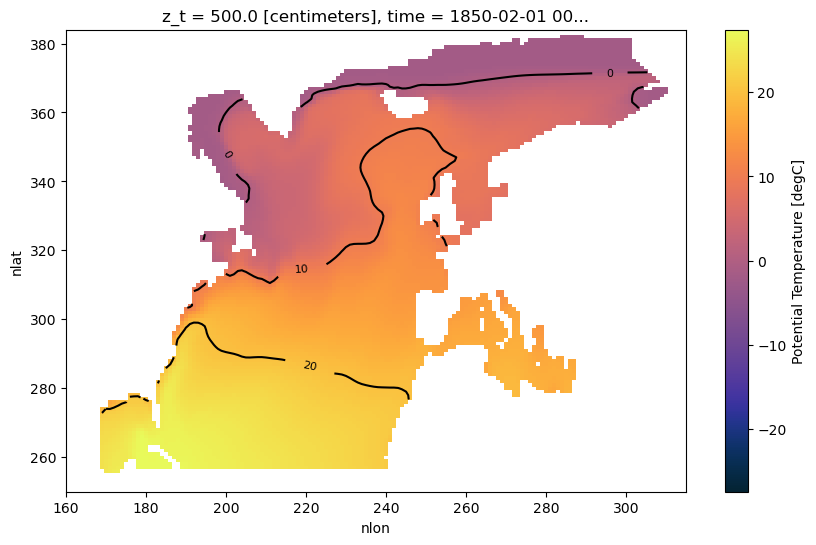

In [81]:
data = ds_sst.TEMP.where(mask3d == 1).roll(nlon=-100)

# Create the plot
plt.figure(figsize=(10, 6))
plot = data.plot(cmap=cmo.thermal)

# Add title and labels
plt.title("Your Title Here")
plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label")

# Add contours
contour = data.plot.contour(colors='k')
plt.clabel(contour, inline=True, fontsize=8)

# Set xlim and ylim
plt.xlim([160, 315])
plt.ylim([250, 384])

# Show the plot
plt.show()

# Sea Surface Salinity

In [6]:
ds_salt = xr.open_dataset(salt_file)
ds_sss = ds_salt.isel(z_t=0)

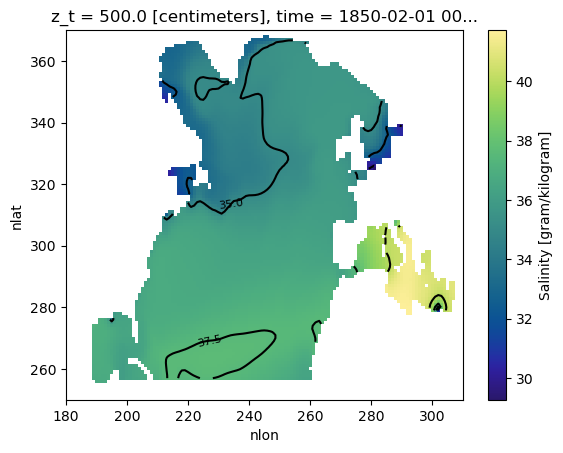

In [7]:
data = ds_sss.SALT.isel(time=0).where(mask3d == 1).roll(nlon=-80)

data.plot(cmap = cmo.haline)
contour = data.plot.contour(colors='k') 
plt.clabel(contour, inline=False, fontsize=8) 
plt.xlim([180, 310])
plt.ylim([250, 370])

plt.show()

In [8]:
ds_sst.TEMP.isel(time=0).where(mask3d == 1).min().values

array(-1.87272322)

In [9]:
ds_sst.TEMP.where(mask3d == 1).min()

<xarray.DataArray 'TEMP' ()>
array(-1.91410971)
Coordinates:
    z_t      float32 500.0

In [10]:
ds_sss.SALT.isel(time=0).where(mask3d == 1).min()

<xarray.DataArray 'SALT' ()>
array(29.26999092)
Coordinates:
    z_t      float32 500.0
    time     object 1850-02-01 00:00:00

In [11]:
t_min, t_max = ds_sst.TEMP.isel(time=0).where(mask3d == 1).min().values, ds_sst.TEMP.isel(time=0).where(mask3d == 1).max().values
s_min, s_max = ds_sss.SALT.isel(time=0).where(mask3d == 1).min().values, ds_sss.SALT.isel(time=0).where(mask3d == 1).max().values

# Animate both during abrupt event

In [12]:
# Define data and plotting functions
def plot_salt_frame(time_step):
    data = ds_sss.SALT.isel(time=start+time_step).where(mask3d == 1).roll(nlon=-80)
    plt.subplot(1, 2, 1)
    plt.cla()
    data.plot(cmap=cmo.haline, vmin=s_min, vmax=s_max)
    contour = data.plot.contour(colors='k')
    plt.clabel(contour, inline=False, fontsize=8)
    plt.xlim([180, 310])
    plt.ylim([250, 370])
    
    # create title
    time_values = ds_sss.time.isel(time=start+time_step).values
    time_objects = np.array(time_values, dtype='datetime64[ns]')
    date = np.datetime_as_string(time_objects, unit='M')
    plt.title(f'SSS - {date}')

def plot_temp_frame(time_step):
    data = ds_sst.TEMP.isel(time=start+time_step).where(mask3d == 1).roll(nlon=-80)
    plt.subplot(1, 2, 2)
    plt.cla()
    data.plot(cmap=cmo.thermal, vmin=t_min, vmax=t_max)
    contour = data.plot.contour(colors='k')
    plt.clabel(contour, inline=True, fontsize=8)
    plt.xlim([180, 310])
    plt.ylim([250, 370])
    plt.title(f'TEMP - Time Step {time_step}')
    
    # create title
    time_values = ds_sst.time.isel(time=start+time_step).values
    time_objects = np.array(time_values, dtype='datetime64[ns]')
    date = np.datetime_as_string(time_objects, unit='M')
    plt.title(f'SST - {date}')

In [13]:
i=0

event_files = ['1281.012.nc', '1301.001.nc', '1281.017.nc', '1231.020.nc', '1281.020.nc', '1281.001.nc']
events = np.array([68,67,44,59,80,154])

temp_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_'
salt_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_'

ds_sst = xr.open_dataset(temp_path+event_files[i]).isel(z_t=0)
ds_sss = xr.open_dataset(salt_path+event_files[i]).isel(z_t=0)

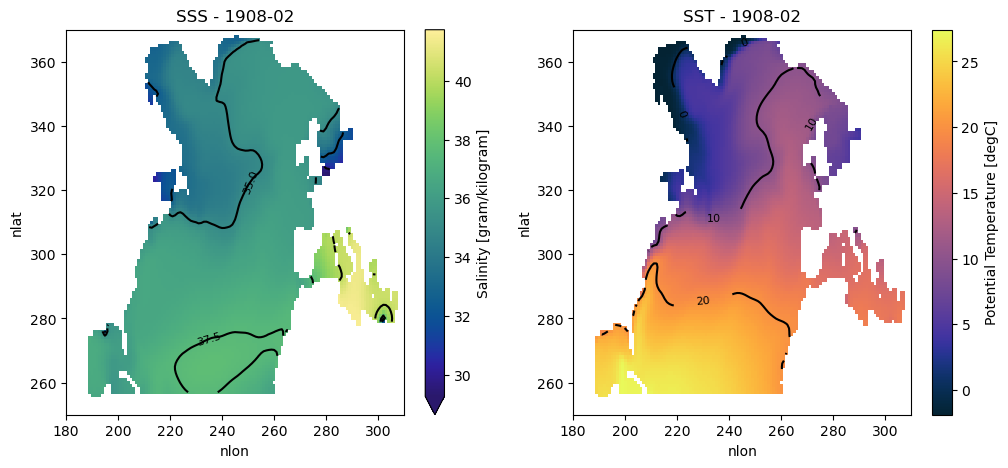

In [14]:
before = 10
after = 10
start  = (events[i]*12)-(before*12)
period = (before+after)*12

# Set up the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Create an animation
#num_time_steps = period  
num_time_steps = 10  
ani = animation.FuncAnimation(fig, lambda x: (plot_salt_frame(x), plot_temp_frame(x)),
                              frames=num_time_steps, interval=800)

# Save
#ani.save(os.path.expanduser('~/phase1_CONDA/results/')+'sst_sss_'+event_files[i][:-3]+'.gif', writer='pillow', fps=3)

# Display the animation
#HTML(ani.to_jshtml())

# Plot differences of averages of before and after

In [83]:
event_files = ['1281.012.nc', '1301.001.nc', '1281.017.nc', '1231.020.nc', '1281.020.nc', '1281.001.nc']
events = np.array([68,67,44,59,80,154])

temp_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_'
salt_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_'

i=0

before = 40*12
after = 20*12
event = (events[i]*12)
tp= 3*12 # transition_period 

ds_sst = xr.open_dataset(temp_path+event_files[i]).isel(z_t=0).where(mask3d == 1).roll(nlon=-100)
ds_sss = xr.open_dataset(salt_path+event_files[i]).isel(z_t=0).where(mask3d == 1).roll(nlon=-100)

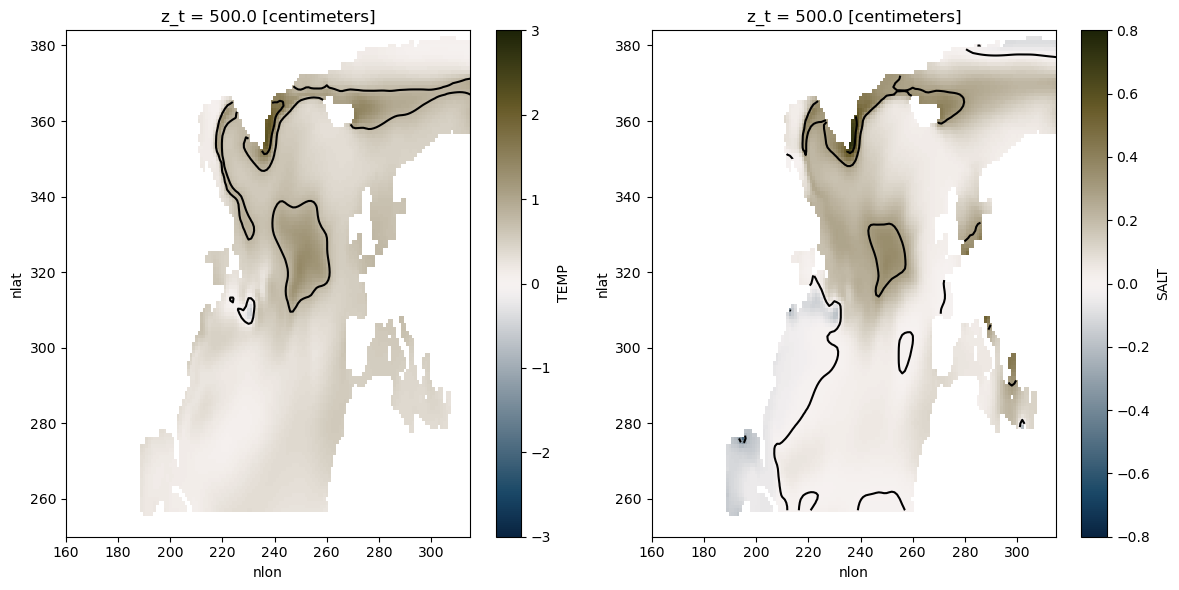

In [85]:
# Set fixed colorbar limits
vmin_temp, vmax_temp = -3.0, 3.0  # Adjust these values based on your data
vmin_salt, vmax_salt = -0.8, 0.8  # Adjust these values based on your data

# Calculate averages for temperature
period1_avg_temp = ds_sst.TEMP.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_temp = ds_sst.TEMP.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_temp = period2_avg_temp - period1_avg_temp

# Calculate averages for salinity
period1_avg_salt = ds_sss.SALT.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_salt = ds_sss.SALT.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_salt = period2_avg_salt - period1_avg_salt

# Plotting
plt.figure(figsize=(12, 6))

# Plot the Difference for Temperature
plt.subplot(121)
difference_temp_plot = difference_temp.plot(cmap=cmo.diff, vmin=vmin_temp, vmax=vmax_temp)
plt.title('Temperature Difference')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_temp = difference_temp.plot.contour(colors='k') 
#plt.clabel(contour_temp, inline=False, fontsize=8)

# Plot the Difference for Salinity
plt.subplot(122)
difference_salt_plot = difference_salt.plot(cmap=cmo.diff, vmin=vmin_salt, vmax=vmax_salt)
plt.title('Salinity Difference')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_salt = difference_salt.plot.contour(colors='k') 
#plt.clabel(contour_salt, inline=False, fontsize=8)

plt.tight_layout()
plt.show()

# Plot avarages of before and after

In [15]:
event_files = ['1281.012.nc', '1301.001.nc', '1281.017.nc', '1231.020.nc', '1281.020.nc', '1281.001.nc']
events = np.array([68,67,44,59,80,154])

temp_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_'
salt_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_'

i=0

before = 40*12
after = 20*12
event = (events[i]*12)
tp= 3*12 # transition_period 

ds_sst = xr.open_dataset(temp_path+event_files[i]).isel(z_t=0).where(mask3d == 1).roll(nlon=-80)
ds_sss = xr.open_dataset(salt_path+event_files[i]).isel(z_t=0).where(mask3d == 1).roll(nlon=-80)

Temperature

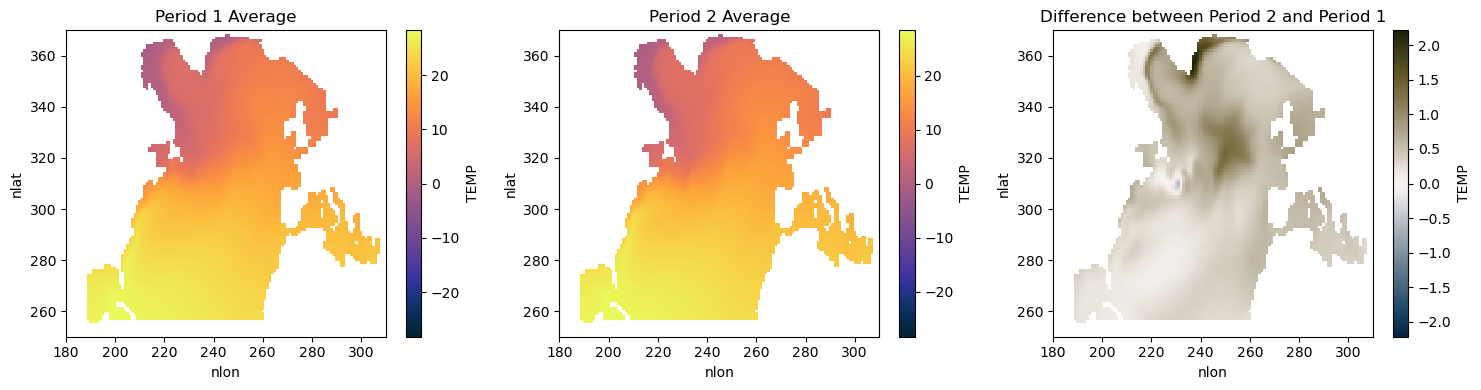

In [22]:
period1_avg = ds_sst.TEMP.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg = ds_sst.TEMP.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference = period2_avg - period1_avg

# Plotting
plt.figure(figsize=(15, 4))

# Plot Period 1 Average
plt.subplot(131)
period1_avg.plot(cmap=cmo.thermal)
plt.title('Period 1 Average')
plt.xlim([180, 310])
plt.ylim([250, 370])

# Plot Period 2 Average
plt.subplot(132)
period2_avg.plot(cmap=cmo.thermal)
plt.title('Period 2 Average')
plt.xlim([180, 310])
plt.ylim([250, 370])

# Plot the Difference
plt.subplot(133)
difference.plot(cmap=cmo.diff)
plt.title('Difference between Period 2 and Period 1')
plt.xlim([180, 310])
plt.ylim([250, 370])

plt.tight_layout()
plt.show()

Salinity

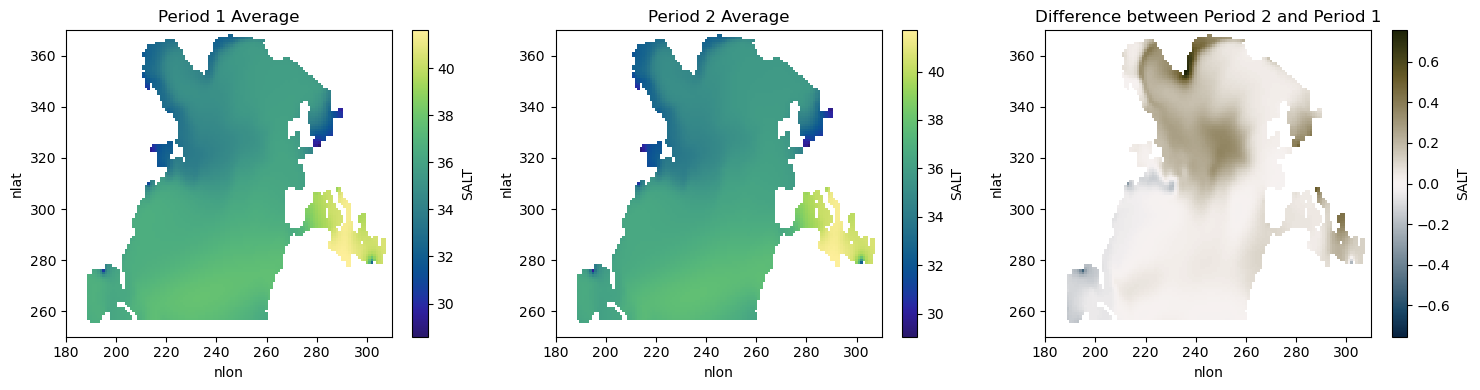

In [23]:
period1_avg = ds_sss.SALT.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg = ds_sss.SALT.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference = period2_avg - period1_avg

# Plotting
plt.figure(figsize=(15, 4))

# Plot Period 1 Average
plt.subplot(131)
period1_avg.plot(cmap=cmo.haline)
plt.title('Period 1 Average')
plt.xlim([180, 310])
plt.ylim([250, 370])

# Plot Period 2 Average
plt.subplot(132)
period2_avg.plot(cmap=cmo.haline)
plt.title('Period 2 Average')
plt.xlim([180, 310])
plt.ylim([250, 370])

# Plot the Difference
plt.subplot(133)
difference.plot(cmap=cmo.diff)
plt.title('Difference between Period 2 and Period 1')
plt.xlim([180, 310])
plt.ylim([250, 370])

plt.tight_layout()
plt.show()

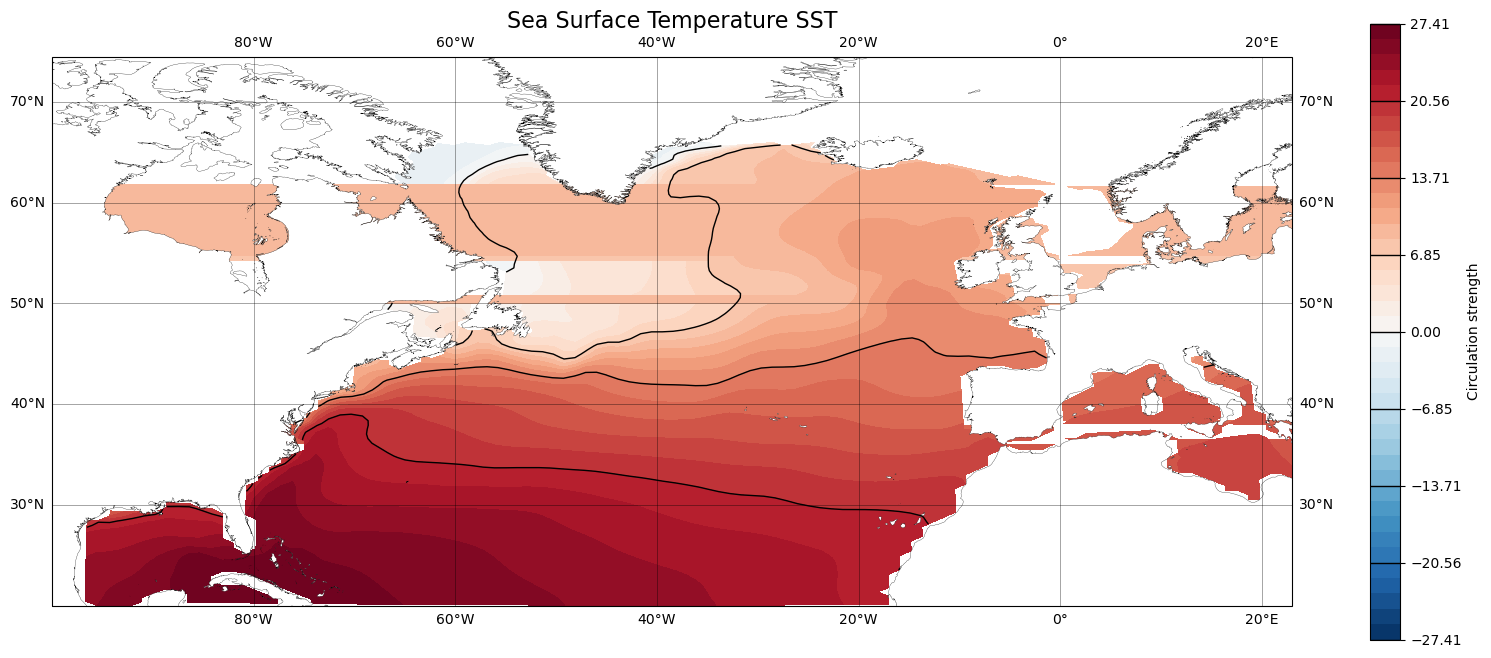

In [27]:
# to center plot roll by 80° longitude
ssh_region = ds_sst.TEMP.isel(time=0).where(mask3d == 1).roll(nlon=-80)

# set kwargs
crs = cartopy.crs.PlateCarree()

vmin = -np.max(np.abs(ssh_region))  # Set vmin to the negative maximum value
vmax = np.max(np.abs(ssh_region))   # Set vmax to the positive maximum value

levels = np.linspace(vmin, vmax, 41)
#cmap = cmo.balance
cmap = 'RdBu_r'
extent = [-100, 23, 20, 60]

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',linewidth=0.2, edgecolor='black', facecolor='white')
title = 'Sea Surface Temperature SST'
save_name = 'BSF.png'
         
fig = plt.figure(figsize=(20,8))
ax = plt.axes(projection=crs)
land = ax.add_feature(nature_coast)
ax.gridlines(crs=crs, linewidth=0.5, color='black', alpha=0.5, linestyle='-', draw_labels=True)

ax.set_title(title, fontsize=16)
# plot map
cf = ax.contourf(ds_sst.TLONG.roll(nlon=-80), ds_sst.TLAT.roll(nlon=-80), ssh_region, levels=levels, cmap = cmap, norm = norm)
# plot contours
cf2 = ax.contour(ds_sst.TLONG.roll(nlon=-80), ds_sst.TLAT.roll(nlon=-80), ssh_region, levels=levels[::5], colors=['k',],linewidths=1, linestyles='solid')
# plot colorbaar
cbar = fig.colorbar(cf, ax=ax)
cbar.ax.set_ylabel('Circulation strength')
# Add the contour line levels to the colorbar
cbar.add_lines(cf2)
ax.set_extent(extent)

plt.show()
#plt.savefig(path+save_name[j], bbox_inches='tight')

In [ ]:
#!/usr/bin/env python3
# inagler 07/11/23

### INITIALISATION ###

import xarray as xr
import pop_tools
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import os                   

# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 
                             'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

event_files = ['1281.012.nc', '1301.001.nc', '1281.017.nc', '1231.020.nc', '1281.020.nc', '1281.001.nc']
events = np.array([68,67,44,59,80,154])

temp_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_'
salt_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_'

### COMPUTATION ###

for i in range(len(event_files)):
    
    before = 40*12
    after = 20*12
    event = (events[i]*12)
    tp= 3*12  

    ds_sst = xr.open_dataset(temp_path+event_files[i]).isel(z_t=0).where(mask3d == 1).roll(nlon=-100)
    ds_sss = xr.open_dataset(salt_path+event_files[i]).isel(z_t=0).where(mask3d == 1).roll(nlon=-100)
    
    # Set fixed colorbar limits
    vmin_temp, vmax_temp = -3.0, 3.0  # Adjust these values based on your data
    vmin_salt, vmax_salt = -0.8, 0.8  # Adjust these values based on your data

    # Calculate averages for temperature
    period1_avg_temp = ds_sst.TEMP.isel(time=slice(event-before, event-tp)).mean(dim='time')
    period2_avg_temp = ds_sst.TEMP.isel(time=slice(event+tp, event+after)).mean(dim='time')
    difference_temp = period2_avg_temp - period1_avg_temp

    # Calculate averages for salinity
    period1_avg_salt = ds_sss.SALT.isel(time=slice(event-before, event-tp)).mean(dim='time')
    period2_avg_salt = ds_sss.SALT.isel(time=slice(event+tp, event+after)).mean(dim='time')
    difference_salt = period2_avg_salt - period1_avg_salt

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot the Difference for Temperature
    plt.subplot(121)
    difference_temp_plot = difference_temp.plot(cmap=cmo.diff, vmin=vmin_temp, vmax=vmax_temp)
    plt.title('Temperature Difference')
    plt.xlim([160, 315])
    plt.ylim([250, 384])
    contour_temp = difference_temp.plot.contour(colors='k') 
    #plt.clabel(contour_temp, inline=False, fontsize=8)

    # Plot the Difference for Salinity
    plt.subplot(122)
    difference_salt_plot = difference_salt.plot(cmap=cmo.diff, vmin=vmin_salt, vmax=vmax_salt)
    plt.title('Salinity Difference')
    plt.xlim([160, 315])
    plt.ylim([250, 384])
    contour_salt = difference_salt.plot.contour(colors='k') 
    #plt.clabel(contour_salt, inline=False, fontsize=8)

    plt.tight_layout()
    plt.show()

